# Module import

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from astra import create_proj_geom, create_vol_geom, create_projector, OpTomo
from scipy.sparse.linalg import LinearOperator


# Data generation
- This code generates a rectangular prism uniformly magnetised in y
- Output will be X, Y, Z and MX, MY, MZ where each is a (200,200,200) grid of coordinates/magnetisation values

In [3]:
# Generate micromagnetic data

n = 200 # number of nodes in each dimension (nxnxn grid)
ndet = n
size_n = 1 # length in nm of each node

# generate each axis
xs = np.linspace(-n * (size_n/2),n * (size_n/2)-size_n,n)
ys = np.linspace(-n * (size_n/2),n * (size_n/2)-size_n,n)
zs = np.linspace(-n * (size_n/2),n * (size_n/2)-size_n,n)

# create grid of values
xx, yy, zz = np.meshgrid(xs,ys, zs,indexing='ij')

# create array of vector coordinates
nx = xx.reshape(n**3)
ny = yy.reshape(n**3)
nz = zz.reshape(n**3)
coor = np.array([nx,ny,nz]).T

# generate empty axes for magnetisation values
Mx = np.zeros_like(xs)
My = np.zeros_like(ys)
Mz = np.zeros_like(zs)

# generate empty grid for magnetisation values
Mxx, Myy, Mzz = np.meshgrid(Mx, My, Mz, indexing='ij')

# choose boundaries of cuboid and return index in axis 
lbx = np.where(xs==-24)[0][0]
ubx = np.where(xs==24)[0][0]

lby = np.where(xs==-32)[0][0]
uby = np.where(xs==32)[0][0]

lbz = np.where(xs==-16)[0][0]
ubz = np.where(xs==16)[0][0]

# Set magnetisation to 1 within specified boundary
Myy[lbx:ubx,lby:uby,lbz:ubz] = 1

m_x, m_y, m_z = Mxx, Myy, Mzz
MX, MY, MZ = Mxx, Myy, Mzz

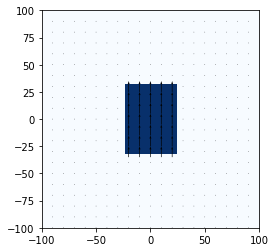

In [4]:
# plot to check
# in this case plot the My values at slice z= 100 
s=10
plt.quiver(xx[::s,::s,round(n/2)],yy[::s,::s,round(n/2)],Mxx[::s,::s,round(n/2)],Myy[::s,::s,round(n/2)],pivot='mid',scale=20)
plt.imshow(Myy[:,:,round(n/2)].T, extent=[-n * (size_n/2),n * (size_n/2),-n * (size_n/2),n * (size_n/2)],cmap='Blues',origin='lower')


In [5]:
# Get grid spacing, size of grid etc.

# Array with unique z coordinates
xuni = np.unique(coor[:,0])
yuni = np.unique(coor[:,1])
zuni = np.unique(coor[:,2])

# Length of each dimension
x_len = len(xuni)
y_len = len(yuni)
z_len = len(zuni)

# Generate mesh
X, Y, Z = np.meshgrid(xuni, yuni, zuni, indexing='ij')

# Recover projected x/y values (for non-rotated data)
x_proj = np.average(X,axis=2)
y_proj = np.average(Y,axis=2)

# Calculate x/y values (for projected data)
det = (ndet,ndet)
x2 = np.linspace(xuni[0],xuni[-1],det[0])
y2 = np.linspace(yuni[0],yuni[-1],det[0])
x_proj2, y_proj2 = np.meshgrid(x2, y2, indexing='ij')

# Calculate grid spacing
x_res = (xuni[1]-xuni[0])
y_res = (yuni[1]-yuni[0])
z_res = (zuni[1]-zuni[0])

# Limits of grid
x_begin = xuni[0] - 0.5*x_res
x_end = xuni[-1] + 0.5*x_res
y_begin = yuni[0] - 0.5*y_res
y_end = yuni[-1] + 0.5*y_res
z_begin = zuni[0] - 0.5*z_res
z_end = zuni[-1] + 0.5*z_res

# Calculate size of grid
x_size = (x_end-x_begin)
y_size = (y_end-y_begin)
z_size = (z_end-z_begin)

# Confirm the dimensions of the image and resolution for the user.
sym_details = 'The data imported has dimensions ' + str(x_size) + ' x ' + str(y_size) + ' x ' + str(z_size) + ' nm,\n'
sym_details += 'and resolution ' + str(x_res) + ' x ' + str(y_res) + ' x ' + str(z_res) + ' nm.\n'
sym_details += 'There are a total of ' + str(z_len) + ' slices in z.'
print(sym_details)

The data imported has dimensions 200.0 x 200.0 x 200.0 nm,
and resolution 1.0 x 1.0 x 1.0 nm.
There are a total of 200 slices in z.


# Functions for rotation/projection

In [6]:
# Define projection functions using astra toolbox

def getGeneralProjGeometry(det, beam, e1, e2):
    V = np.hstack((beam, np.zeros((len(beam),3)), e2, e1))
    return create_proj_geom('parallel3d_vec', *det, V)

def getGeneralVolGeometry(sz):
    return create_vol_geom(sz[1], sz[2], sz[0])

def getGeneralProjector(sz, det, beam, e1, e2):
    vol = getGeneralVolGeometry(sz)
    proj = getGeneralProjGeometry(det, beam, e1, e2)
    ID = create_projector('cuda3d', proj, vol)
    #ID = create_projector('cuda3d', proj, vol)
    return OpTomo(ID)

class vectorProjector(LinearOperator):

    def __init__(self, proj, dom, ran, vsize=None):
        dim = 3 if proj.appendString[:1] == '3' else 2
        if vsize is None:
            vsize = max(np.prod(dom[dim:]), np.prod(ran[dim:]))
        LinearOperator.__init__(self, 'float32', (vsize * np.prod(ran[:dim]), vsize * np.prod(dom[:dim])))
        self.proj = proj
        self.dim = dim
        self.dom, self.ran = dom, ran
        self._transpose = self._adjoint

    def FP(self, u):
        u = u.reshape(*self.dom[:self.dim], -1)
        v = [self.proj.FP(u[..., i])[..., None]
             for i in range(u.shape[-1])]
        return np.concatenate(v, axis=-1).reshape(self.ran)

    def BP(self, u):
        u = u.reshape(*self.ran[:self.dim], -1)
        v = [self.proj.BP(u[..., i])[..., None]
             for i in range(u.shape[-1])]
        return np.concatenate(v, axis=-1).reshape(self.dom)
    
    _matvec, _rmatvec = FP, BP

class tensorProjector(LinearOperator):

    def __init__(self, proj, dom, ran, beam):
        P = vectorProjector(proj, dom, ran)
        LinearOperator.__init__(self, 'float32', P.shape)
        self.proj = P
        self.beam = beam
        self._transpose = self._adjoint

    def FP(self, u): return self.proj.FP(u)

    def BP(self, u): return self.proj.BP(u)

    def norm(self): return self.proj.norm()

    _matvec, _rmatvec = FP, BP


def getVecProj(sz, det, beam, e1, e2, size=(1,)):
    size = tuple(size) if hasattr(size, '__iter__') else (size,)
    proj = getGeneralProjector(sz, det, beam, e1, e2)
    dom = tuple(sz) + size
    ran = (det[0], len(beam), det[1]) + size
    # changed this to vector projector
    return tensorProjector(proj, dom, ran, beam)

component_plotter(MX, MY, MZ, 33, -50, 0)

NameError: name 'component_plotter' is not defined

In [ ]:
# Define projection functions using astra toolbox - NO GPU

def getGeneralProjGeometry(det, beam, e1, e2):
    V = np.hstack((beam, np.zeros((len(beam),3)), e2, e1))
    return create_proj_geom('parallel3d_vec', *det, V)

def getGeneralVolGeometry(sz):
    return create_vol_geom(sz[1], sz[2], sz[0])

def getGeneralProjector(sz, det, beam, e1, e2):
    vol = getGeneralVolGeometry(sz)
    proj = getGeneralProjGeometry(det, beam, e1, e2)
    
    #pacingX':args[0], 'DetectorSpacingY':args[1], 'DetectorRowCount':args[2], 'DetectorColCount':args[3],'ProjectionAngles
    ID = create_projector('cuda3d', proj, vol)
    return OpTomo(ID)

class vectorProjector(LinearOperator):

    def __init__(self, proj, dom, ran, vsize=None):
        dim = 3 if proj.appendString[:1] == '3' else 2
        if vsize is None:
            vsize = max(np.prod(dom[dim:]), np.prod(ran[dim:]))
        LinearOperator.__init__(self, 'float32', (vsize * np.prod(ran[:dim]), vsize * np.prod(dom[:dim])))
        self.proj = proj
        self.dim = dim
        self.dom, self.ran = dom, ran
        self._transpose = self._adjoint

    def FP(self, u):
        u = u.reshape(*self.dom[:self.dim], -1)
        v = [self.proj.FP(u[..., i])[..., None]
             for i in range(u.shape[-1])]
        return np.concatenate(v, axis=-1).reshape(self.ran)

    def BP(self, u):
        u = u.reshape(*self.ran[:self.dim], -1)
        v = [self.proj.BP(u[..., i])[..., None]
             for i in range(u.shape[-1])]
        return np.concatenate(v, axis=-1).reshape(self.dom)
    
    _matvec, _rmatvec = FP, BP

class tensorProjector(LinearOperator):

    def __init__(self, proj, dom, ran, beam):
        P = vectorProjector(proj, dom, ran)
        LinearOperator.__init__(self, 'float32', P.shape)
        self.proj = P
        self.beam = beam
        self._transpose = self._adjoint

    def FP(self, u): return self.proj.FP(u)

    def BP(self, u): return self.proj.BP(u)

    def norm(self): return self.proj.norm()

    _matvec, _rmatvec = FP, BP


def getVecProj(sz, det, beam, e1, e2, size=(1,)):
    size = tuple(size) if hasattr(size, '__iter__') else (size,)
    proj = getGeneralProjector(sz, det, beam, e1, e2)
    dom = tuple(sz) + size
    ran = (det[0], len(beam), det[1]) + size
    # changed this to vector projector
    return tensorProjector(proj, dom, ran, beam)

component_plotter(MX, MY, MZ, 33, -50, 0)

In [7]:
# define projection function which uses astra code above

# KEY: rotations about x/y/z depend on the order in which you apply them
# This code will rotate about z, then y, then x.
# Note that the x,y,z axes are defined with respect to the originial orientation
# of the the shape itself (i.e. these rotations are relative to a set of axes
# that are 'attached' to the actual object)

def rotation_projection(MX,MY,MZ, ax=0,ay=0,az=0):
    """ Given 3D gridded magnetisation values MX,MY,MZ, returns x,y,z magnetisation 
    values projected in 2D.
    By default projects for beam parallel to z axis, but this can be modified by changing
    angles ax/ay/az to project as if the sample had been rotated about the x/y/z axes by 
    the amounts specified"""
    detsize = np.shape(MX)[0]#ndet
    sz, det = (x_len, y_len, z_len), (detsize, detsize)
    
    # Calculate rotation matrix
    ax = ax * np.pi/180
    Cx = np.cos(ax)
    Sx = np.sin(ax)
    mrotx = np.array([[1,0,0],[0,Cx,-Sx],[0,Sx,Cx]])
    
    ay = ay * np.pi/180
    Cy = np.cos(ay)
    Sy = np.sin(ay)
    mroty = np.array([[Cy,0,Sy],[0,1,0],[-Sy,0,Cy]])
    
    az = az * np.pi/180
    Cz = np.cos(az)
    Sz = np.sin(az)
    mrotz = np.array([[Cz,-Sz,0],[Sz,Cz,0],[0,0,1]])
    
    mrot = mrotz.dot(mroty).dot(mrotx)

    # pass rotation matrix into astra beam/detector configuration
    # e1 and e2 are perpendicular axes of the detector
    beam = np.array([[mrot[2][2],mrot[2][1],mrot[2][0]],[0,0,0]]) # z
    e1 = np.array([[mrot[1][2],mrot[1][1],mrot[1][0]],[0,0,0]]) # y
    e2 = np.array([[mrot[0][2],mrot[0][1],mrot[0][0]],[0,0,0]]) # x
    
    # reshape x,y,z magnetisation into u
    u = np.concatenate([thing.reshape(*thing.shape[:3],1) for thing in (MX, MY, MZ)], axis=3)

    # Project data along given axis
    R = getVecProj(u.shape[:3], det, beam, e1, e2, 3)
    Ru = R.FP(u)
    
    # extract projected m vectors
    mxf = Ru[:,0,:,0].reshape(detsize**2)
    myf = Ru[:,0,:,1].reshape(detsize**2)
    mzf = Ru[:,0,:,2].reshape(detsize**2)

    Ms = np.array([mxf,myf,mzf])

    Msr = []

    # rotate vectors by specified amount
    for i in range(detsize**2):
        x, y, z = Ms[0][i],Ms[1][i],Ms[2][i]

        res = mrot.dot(np.array([x,y,z])) 
        xr,yr,zr = res[0], res[1], res[2]
        Msr.append([xr,yr,zr])

    # reshape coordinates into 2D grids (nxn)
    Msr = np.array(Msr)
    Mxr = np.take(Msr,0,axis=1)
    Myr = np.take(Msr,1,axis=1)
    Mzr = np.take(Msr,2,axis=1)

    Mxr = Mxr.reshape(detsize,detsize)/detsize
    Myr = Myr.reshape(detsize,detsize)/detsize
    Mzr = Mzr.reshape(detsize,detsize)/detsize
     
    Mxr = Mxr.T
    Myr = Myr.T
    Mzr = Mzr.T 

    return Mxr, Myr, Mzr

In [8]:
# plot rotated magnetic components

def component_plotter(MX,MY,MZ, theta_x, theta_y, theta_z):
    
    # call projection function
    Mxr, Myr, Mzr = rotation_projection(MX,MY,MZ,ax=theta_x,ay=theta_y, az=theta_z)

    # Set up figure
    fig = plt.figure(figsize=(16, 12))
    grid = plt.GridSpec(3, 4)
    ax1 = fig.add_subplot(grid[0, 0])
    ax2 = fig.add_subplot(grid[1, 0])
    ax3 = fig.add_subplot(grid[2, 0])
    ax4 = fig.add_subplot(grid[:, 1:])
    
    # scale factor
    sf = 1

    # plot Mx
    pos =  ax1.imshow(np.flipud(Mxr.T), vmin=-1*sf,vmax=1*sf, extent=[x_begin, x_end, y_begin, y_end],cmap='RdBu'); 
    ax1.set_title('Mx',fontsize=16); ax1.set_xlabel('x',fontsize=14);ax1.set_ylabel('y',fontsize=14); fig.colorbar(pos,ax=ax1,fraction=0.046, pad=0.04)

    # Plot My
    pos = ax2.imshow(np.flipud(Myr.T), vmin=-1*sf,vmax=1*sf,extent=[x_begin, x_end, y_begin, y_end],cmap='RdBu');
    ax2.set_title('My',fontsize=16); ax2.set_xlabel('x',fontsize=14);ax2.set_ylabel('y',fontsize=14); fig.colorbar(pos,ax=ax2,fraction=0.046, pad=0.04)

    #Plot Mz
    pos = ax3.imshow(np.flipud(Mzr.T), vmin=-1*sf,vmax=1*sf,extent=[x_begin, x_end, y_begin, y_end],cmap='RdBu');
    #pos = ax3.contourf(x_proj,y_proj,Mzr,cmap='RdBu',vmin=-1,vmax=1)
    ax3.set_title('Mz',fontsize=16); ax3.set_xlabel('x',fontsize=14);ax3.set_ylabel('y',fontsize=14); fig.colorbar(pos,ax=ax3,fraction=0.046, pad=0.04)

    # Plot projection
    s=5
    size = 0.1
    mag_B = np.hypot(Mxr,Myr)

    # M magnitude plot
    pos = ax4.imshow(np.flipud(mag_B.T),extent=[-100, 100, -100, 100],cmap='Blues', vmin=0,vmax=np.max(mag_B))
    clb = fig.colorbar(pos,ax=ax4,fraction=0.046, pad=0.04)
    clb.ax.set_title(r'|$\bf{M}$$_\perp$|') 
    
    # Vector plot
    ax4.quiver(x_proj[::s,::s],y_proj[::s,::s],Mxr[::s,::s],Myr[::s,::s],scale = 10*sf, pivot='mid')
    ax4.set_title(r'$\bf{M}$$_\perp$ for %i$^{\circ}$, %i$^{\circ}$, %i$^{\circ}$ rotations about x, y and z' % (theta_x, theta_y, theta_z), fontsize=25); ax4.set_xlabel('x',fontsize=16);ax4.set_ylabel('y',fontsize=16); 

    #plt.xlim([0,100])
    #plt.ylim([0,100])
    
    plt.tight_layout()

# Plot Rotated object

In [63]:
component_plotter(MX, MY, MZ, 33, -50, 0)

Exception: Error creating projector.